In [52]:
import pickle
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
import gc
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer

In [2]:
with open ('../input/cm-trips/cm_trips', 'rb') as fp:
    tripdata = pickle.load(fp)
tripdata.reset_index(drop=True, inplace=True)

In [ ]:
tripdata.head()

Добавим новый признак - "Продолжительность поездки" в минутах

In [3]:
tripdata['trip_duration'] = (pd.to_datetime(tripdata.tpep_dropoff_datetime) - pd.to_datetime(tripdata.tpep_pickup_datetime)).astype('timedelta64[m]')

In [4]:
num_feats = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
               'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']
nom_feats = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 
               'payment_type']

In [ ]:
tripdata[num_feats+['total_amount']].describe()

In [ ]:
tripdata[nom_feats].describe(include='all')

### Anomaly analysis

Из таблицы выше видно, что почти у всех  вещественных признаков (за исключением количества пассажиров) минимальные значения отрицательны, что, разумеется, не нормально. Также можно отметить поездки с нулевым количеством пассажиров, нулевой дальностью, длительностью и стоимостью поездки, значением RatecodeID '99', которого нет в официальном списке от TLC. Кроме того, из данной таблицы видно, что максимальные значения практически всех вещественных признаков значительно превосходят как средние значения по признаку, так и 3ий квартиль. Такие поездки, на мой взгляд, также следует рассматривать как аномальные и изучать дополнительно, как и поездки, где параметры значительно меньше 1го квартиля. Также к аномальным поездкам можно отнести вызов из/в регионы, где количество поездок крайне малО. Аномалией можно считать и выбросы, т.е. такие поездки, значения параметров которых выходят за рамки [Q1-1.5IQR, Q3+1.5IQR], но все же лучше руководствоваться бизнес задачами для их определения.

In [5]:
bad_trips = tripdata[(tripdata['total_amount'] <= 0) |
                    (tripdata['trip_distance'] <= 0)  |
                    (tripdata['fare_amount'] <= 0) |
                    (tripdata['extra'] < 0) | 
                    (tripdata['mta_tax'] < 0) |
                    (tripdata['tip_amount'] < 0) | 
                    (tripdata['tolls_amount'] < 0) |
                    (tripdata['improvement_surcharge'] < 0) |
                    (tripdata['congestion_surcharge'] < 0) |
                    (tripdata['passenger_count'] <= 0) |
                    (tripdata['trip_duration'] <= 0) |
                    (tripdata['RatecodeID'] == 99)
                   ]

Отфильтруем данные аномалии и заменим значения в store_and_fwd_flag на 0 и 1

In [6]:
tripdata = tripdata[~tripdata.isin(bad_trips)].dropna()
tripdata['store_and_fwd_flag'] = tripdata['store_and_fwd_flag'].map({'N':0,'Y':1})

Переменная bad trips более не понадобится, поэтому можно ее удалить, а заодно и остаточный мусор

In [7]:
del bad_trips
gc.collect()

69

Построим boxplot'ы для вещественных признаков, чтобы наглядно видеть выбросы. Признак total_amount рассмотрим отдельно для удобства.

In [ ]:
plt.rcParams["figure.figsize"] = (16,12)
fig, ax = plt.subplots(3, 3)
fig.subplots_adjust(hspace=.5)
for i in range(len(num_feats)):
    ax[i//3,i%3].set_xlim(-5, 20+2*stats.scoreatpercentile(tripdata[num_feats[i]], 75))
    sns.boxplot(x=num_feats[i], data = tripdata, ax=ax[i//3,i%3])

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plt.xlim(-5, 10*stats.scoreatpercentile(tripdata['total_amount'], 75))
sns.boxplot(x='total_amount', data = tripdata);

Некоторые аномалии можно определить согласно графикам выше. Например, для параметра exta есть выброс в районе 14 долларов, когда данный параметр включает в себя доплату за часы пик в размере 50 центов или 1 доллар и ночные часы. Возможно, имеет смысл детальнее рассмотреть данную поездку. Однако, данные графики никак не учитывают взаимодействие признаков, ведь, например, высокая стоимость поездки по счетчику может объясняться большой дальностью поездки и т.д. Можно попробовать определить аномалии, построив scatter-plot'ы некоторых параметров.

In [ ]:
plt.rcParams["figure.figsize"] = (16,4)
fig, ax = plt.subplots(1,3)
ax[0].scatter(tripdata.fare_amount, tripdata.trip_duration)
ax[0].set_xlabel("Fare amount, dollars")
ax[0].set_ylabel("Trip duration, minutes")
ax[1].scatter(tripdata.fare_amount, tripdata.trip_distance)
ax[1].set_xlabel("Fare amount, dollars")
ax[1].set_ylabel("Trip distance, miles")
ax[2].scatter(tripdata.trip_duration, tripdata.trip_distance)
ax[2].set_xlabel("Trip duration, minutes")
ax[2].set_ylabel("Trip distance, miles");

Интерес представляют поездки, точки которых имеют крайне большие значения либо лежат на какой-либо из осей или сильно к ним прижаты.

Для учета всех признаков можно поставить полноценную задачу поиска аномалий и свести ее, например, к бинарной классификации, а решать с помощью метода опорных векторов с каким-либо нелинейным ядром. Я не уверен, что это требуется в рамках данного задания, поэтому приводить эти выкладки здесь не стал.

### Correlation analysis

Немного отфильтруем данные, чтобы выбросы не искажали картину для корреляции

In [8]:
tripdata = tripdata[(tripdata.total_amount<30) & (tripdata.trip_distance < 10) & 
             (tripdata.trip_duration < 40) & (tripdata.tip_amount < 10) & (tripdata.tolls_amount < 5)]

Рассчитаем коэффициенты корреляции вещественных признаков с целевой переменной в 2х вариантах: Пирсона и Спирмена.

In [9]:
tripdata[num_feats+['trip_duration']].corrwith(tripdata.total_amount)

passenger_count          0.01
trip_distance            0.84
fare_amount              0.95
extra                    0.04
mta_tax                 -0.00
tip_amount               0.56
tolls_amount             0.01
improvement_surcharge    0.00
congestion_surcharge     0.11
trip_duration            0.89
dtype: float64

In [10]:
tripdata[num_feats+['trip_duration']].corrwith(tripdata.total_amount, method='spearman')

passenger_count          0.02
trip_distance            0.86
fare_amount              0.95
extra                    0.07
mta_tax                 -0.00
tip_amount               0.55
tolls_amount             0.01
improvement_surcharge    0.00
congestion_surcharge     0.13
trip_duration            0.91
dtype: float64

Результаты интуитивно понятны. Сильная корреляция с общей стоимостью поездки прослеживается у длинны поездки, суммы поездки по счетчику и времени поездки. Действительно, чем больше расстояние и время, нужное для его преодоления, тем больше стоимость поездки. Сумма по счетчику практически единолично определяет итоговую сумму, к ней добавляются различные доплаты и налоги, которые, как правило, незначительны по сравнению с суммой по счетчику. Менее сильная корреляция- у суммы чаевых. Здесь эта корреляция объясняется тем, что сумма чаевых - это какой то небольшой процент от суммы поездки, и, очевидно, что эти значения коррелируют. Остальные доплаты и налоги на чек практически не влияют.

Для рассчета корреляции вещественного признака с категориальными, коэффициенты Спирмена и Пирсона не применяются. Т.е вычислить их, конечно, можно, но они ни о чем не будут говорить. Поэтому можно либо построить boxplot'ы, чтобы понять, меняются ли средние в зависимости от значений категориального признака, либо применить критерий Краскелла-Уоллеса(либо ANOVA, если бы были выполнены требования о нормальности и гомоскедастичности), но объектов очень много, поэтому, скорее всего, критерий всегда будет иметь крайне малый p-value

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots(2,2)
sns.boxplot(x='VendorID',y='total_amount', data = tripdata, ax=ax[0,0])
ax[0,0].set_ylim(0,150)
sns.boxplot(x='store_and_fwd_flag',y='total_amount', data = tripdata, ax=ax[0,1])
ax[0,1].set_ylim(0,150)
sns.boxplot(x='RatecodeID',y='total_amount', data = tripdata, ax=ax[1,0])
ax[1,0].set_ylim(0,150)
sns.boxplot(x='payment_type',y='total_amount', data = tripdata, ax=ax[1,1])
ax[1,1].set_ylim(0,150);

Из графиков видно, что VendorID и store_and_fwd_flag не влияют на сумму поездки. Payment type влияет незначительно, а вот RatecodeID влияет очень сильно, что неудивительно, так как судя по пояснению TLC, RatecodeID зависит от точки высадки.

Признаки PULocationID и DOLocationID имеют очень много значений, поэтому имеет смысл рассмотреть их отдельно и не для всех значений.

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,1)
sns.boxplot(x='PULocationID',y='total_amount', data = tripdata[tripdata['PULocationID'].isin(tripdata.PULocationID.value_counts().index[0:20])], ax=ax[0])
ax[0].set_ylim(0,100)
sns.boxplot(x='DOLocationID',y='total_amount', data = tripdata[tripdata['DOLocationID'].isin(tripdata.DOLocationID.value_counts().index[20:40])], ax=ax[1])
ax[1].set_ylim(0,100);

Видно,что некоторые регионы имеют существенно больший средний чек, чем другие. Следовательно, данные признаки также влияют на цену поездки.

### Trip cost distribution

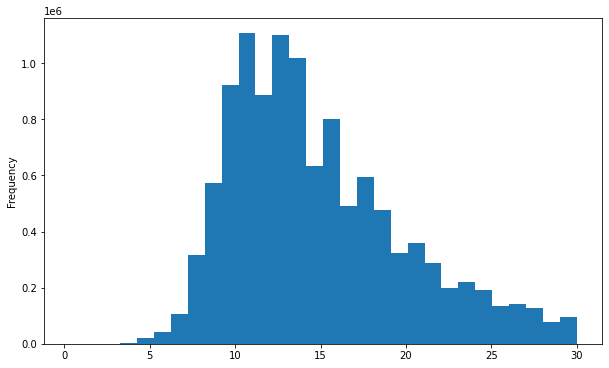

In [64]:
plt.rcParams["figure.figsize"] = (10,6)
tripdata.total_amount.plot.hist(bins=30);

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


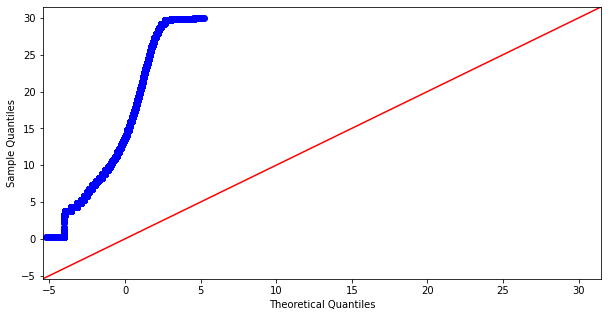

In [25]:
plt.rcParams["figure.figsize"] = (10,5)
sm.qqplot(tripdata.total_amount.values, line='45');

Судя по графикам, распределение стоимости поездки не похоже на нормальное. Формально это можно проверить, например, с помощью кретерия Шапиро-Уилка, но на таком объеме данных он гарантированно будет отвергать нормальность, поэтому лучше пользоваться qq-графиком. Такое распределение, возможно, обусловлено тем, что большинство поездок совершаются в центре города, а по мере удаления от центра, количество таких поездок уменьшается, но стоимость каждой увеличиается.

### Trip cost prediction

Так как на категориальных признаках не определен порядок, нужно такие признаки закодировать. Можно, например, попробовать применить target encoding. Так как у признаков PULocationID и DOLocationID достаточно много значений, применение one hot encoding(или dummy encoding) существенно увеличило бы размерность матрицы объекты-признаки, и ее нужно было хранить в sparse-формате.

In [9]:
te = TargetEncoder()
y = tripdata.total_amount
X_nom = te.fit_transform(tripdata[nom_feats].astype(str), y)
X = pd.concat([tripdata[num_feats+['trip_duration']],X_nom], axis = 1)
del X_nom
gc.collect()

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0

Посмотрим на масштаб признаков, чтобы оценить одинаков ли он

In [10]:
X.apply(np.mean,axis=0)

passenger_count          1.56
trip_distance            1.84
fare_amount              9.60
extra                    1.09
mta_tax                  0.50
tip_amount               1.70
tolls_amount             0.00
improvement_surcharge    0.30
congestion_surcharge     2.37
trip_duration           10.87
VendorID                14.80
RatecodeID              14.80
store_and_fwd_flag      14.80
PULocationID            14.80
DOLocationID            14.80
payment_type            14.80
dtype: float64

Масштаб признаков отличается, можно применить standard scaler, чтобы сделать его одинаковым по признакам

In [37]:
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X),columns=num_feats+['trip_duration']+nom_feats)
del X
gc.collect()

91

Посмотрим как признаки коррелируют между собой

In [38]:
X_scaled.corr()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,trip_duration,VendorID,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type
passenger_count,1.00,0.01,0.01,-0.13,0.00,-0.01,0.00,0.00,0.01,0.01,0.15,-0.00,-0.02,0.01,0.00,-0.02
trip_distance,0.01,1.00,0.89,-0.03,0.00,0.24,0.02,-0.00,-0.11,0.67,0.02,0.01,0.00,0.25,0.45,-0.03
fare_amount,0.01,0.89,1.00,-0.00,-0.01,0.30,0.01,-0.00,-0.05,0.92,0.00,0.03,0.00,0.22,0.35,-0.03
extra,-0.13,-0.03,-0.00,1.00,-0.00,0.03,-0.00,-0.00,0.14,0.01,-0.91,-0.00,0.12,0.02,-0.04,0.03
mta_tax,0.00,0.00,-0.01,-0.00,1.00,0.01,-0.00,-0.05,0.04,0.00,0.01,-0.28,-0.00,-0.00,-0.00,0.01
tip_amount,-0.01,0.24,0.30,0.03,0.01,1.00,-0.00,0.01,0.15,0.31,0.01,-0.01,-0.00,0.06,0.03,0.75
tolls_amount,0.00,0.02,0.01,-0.00,-0.00,-0.00,1.00,-0.00,-0.04,0.00,-0.00,0.00,0.00,-0.00,0.02,-0.00
improvement_surcharge,0.00,-0.00,-0.00,-0.00,-0.05,0.01,-0.00,1.00,0.00,-0.01,-0.01,0.00,0.00,-0.00,-0.00,0.02
congestion_surcharge,0.01,-0.11,-0.05,0.14,0.04,0.15,-0.04,0.00,1.00,0.04,-0.01,-0.04,-0.00,0.06,-0.31,0.14
trip_duration,0.01,0.67,0.92,0.01,0.00,0.31,0.00,-0.01,0.04,1.00,-0.00,-0.00,0.00,0.15,0.20,-0.01


Видим, что некоторые признаки коррелируют достаточно сильно. Это может привести к проблеме мультиколлинеарности. Нужно внимательно следить за коэффициентами модели и использовать регуляризацию

Обучим линейную регрессию. Для этого сначала разобьем данные на тренировочные и тестовые

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size=0.3,random_state=21)

In [46]:
ridgereg = Ridge()
ridgereg.fit(X_train,y_train)
predictions = ridgereg.predict(X_test)

In [48]:
for pair in list(zip(X_scaled.columns,ridgereg.coef_)):
    print("{}: {}".format(pair[0],round(pair[1],3)))

passenger_count: 0.001
trip_distance: 0.052
fare_amount: 4.347
extra: 0.843
mta_tax: 0.003
tip_amount: 1.416
tolls_amount: 0.03
improvement_surcharge: 0.002
congestion_surcharge: 0.425
trip_duration: 0.062
VendorID: 0.774
RatecodeID: -0.0
store_and_fwd_flag: 0.001
PULocationID: -0.0
DOLocationID: 0.003
payment_type: 0.002


In [49]:
ridgereg.score(X_test,y_test)

0.9979557273789351

In [50]:
mean_absolute_error(y_test,predictions)

0.14040052717556353

Видим, что $R^2$ оказался очень высоким, а ошибка - очень низкой. Это подозрительно, но стоит учитывать, что целевая переменная по сути представлят собой сумму поездки по счетчику + всевозможные доплаты и чаевые

Для оценки качества модели нужно еще провеси анализ остатков

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_amount'>

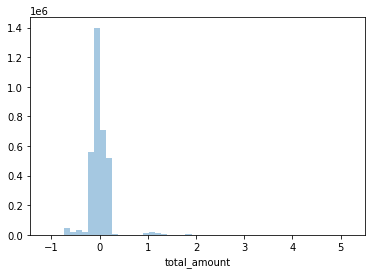

In [56]:
sns.distplot(y_test-predictions, kde=False)

Видим,что в среднем остатки нулевые, и распределение напоминает нормальное

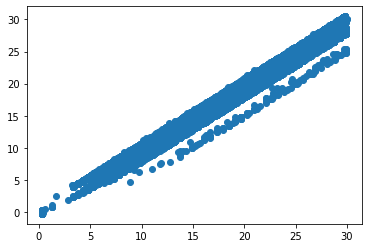

In [57]:
plt.scatter(y_test, predictions)

In [62]:
(predictions - y_test).max()

1.1252422270709062

Из графика и данных выше видно, что были поездки, где прогнозы превосходили фактическую стоимость. Возможно, это можно отнести к скидкам